<a href="https://colab.research.google.com/github/Will-Fahie/galaxy-classifier-neural-network/blob/main/galaxy_classification_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying galaxy morphologies using deep learning
Data set: https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge

In [1]:
train = False

dir = "/content/drive/MyDrive/Galaxy Classification/"
data_dir = dir + "data/"

if train is False:
  model_dir = "/content/drive/MyDrive/Galaxy Classification/model-1630188214/model"
  history_dir = "/content/drive/MyDrive/Galaxy Classification/model-1630188214/history"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
import tensorflow.keras.optimizers as optimizers

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle

%matplotlib inline

import tensorflow as tf
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU available!")

GPU available!


In [4]:
classes = pd.read_csv(data_dir+"solutions.csv").columns[2:]

## If train is True:

In [ ]:
def show_image(index, x, y):
    image = x[index] * 255.0
    class_name = classes[y[index].argmax()]
    probability = max(y[index])
    plt.imshow(image)
    plt.title(f"{class_name} with {format(probability, '.2f')} condifence")
    plt.axis("off")

show_image(10000, x_train, y_train)

In [ ]:
x_train = np.load(data_dir+"x_train.npy")
y_train = np.load(data_dir+"y_train.npy")

In [ ]:
model = Sequential()

model.add(layers.Conv2D(128, (3, 3), input_shape=(64, 64, 3)))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(256, (3, 3)))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(512, (3, 3)))
model.add(layers.Activation("relu"))
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.25))

model.add(layers.Dense(256))
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(128))
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(128))
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(37))
model.add(layers.Activation("sigmoid"))

model.compile(loss="binary_crossentropy", 
              optimizer=optimizers.Adam(learning_rate=0.0003), 
              metrics=[tf.keras.metrics.RootMeanSquaredError(), "accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 128)       3584      
_________________________________________________________________
activation (Activation)      (None, 62, 62, 128)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 256)       295168    
_________________________________________________________________
activation_1 (Activation)    (None, 29, 29, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 512)       1

In [ ]:
%%time

if train:
  history = model.fit(x_train, y_train, verbose=1, epochs=50, batch_size=32, shuffle=True)
  history = history.history

  model_dir = dir+"model-"+str(int(time.time()))
  model.save(model_dir+"/model")

  with open(model_dir+"/history", 'wb') as file:
    pickle.dump(history, file)

Epoch 1/50
750/750 [==============================] - 57s 39ms/step - loss: 0.3288 - root_mean_squared_error: 0.1908 - accuracy: 0.5648
Epoch 2/50
750/750 [==============================] - 29s 39ms/step - loss: 0.3032 - root_mean_squared_error: 0.1667 - accuracy: 0.5987
Epoch 3/50
750/750 [==============================] - 29s 39ms/step - loss: 0.2995 - root_mean_squared_error: 0.1632 - accuracy: 0.5988
Epoch 4/50
750/750 [==============================] - 29s 39ms/step - loss: 0.2952 - root_mean_squared_error: 0.1593 - accuracy: 0.5975
Epoch 5/50
750/750 [==============================] - 29s 39ms/step - loss: 0.2931 - root_mean_squared_error: 0.1574 - accuracy: 0.5979
Epoch 6/50
750/750 [==============================] - 29s 39ms/step - loss: 0.2922 - root_mean_squared_error: 0.1566 - accuracy: 0.5973
Epoch 7/50
750/750 [==============================] - 29s 39ms/step - loss: 0.2910 - root_mean_squared_error: 0.1554 - accuracy: 0.5992
Epoch 8/50
750/750 [============================

## If train is False:

In [5]:
if not train:
  model = tf.keras.models.load_model(model_dir)
  history = pickle.load(open(history_dir, "rb"))

## Evaluating the model

In [6]:
def plot_history(history):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
  fig.set_size_inches(20, 8)

  ax1.plot(history["loss"])
  ax1.set_ylabel("Loss")
  ax1.set_xlabel("No. epoch")

  ax2.plot(history["accuracy"])
  ax2.set_ylabel("Accuracy")
  ax2.set_xlabel("No. epoch")

  ax3.plot(history["root_mean_squared_error"])
  ax3.set_ylabel("RMSE")
  ax3.set_xlabel("No. epoch");

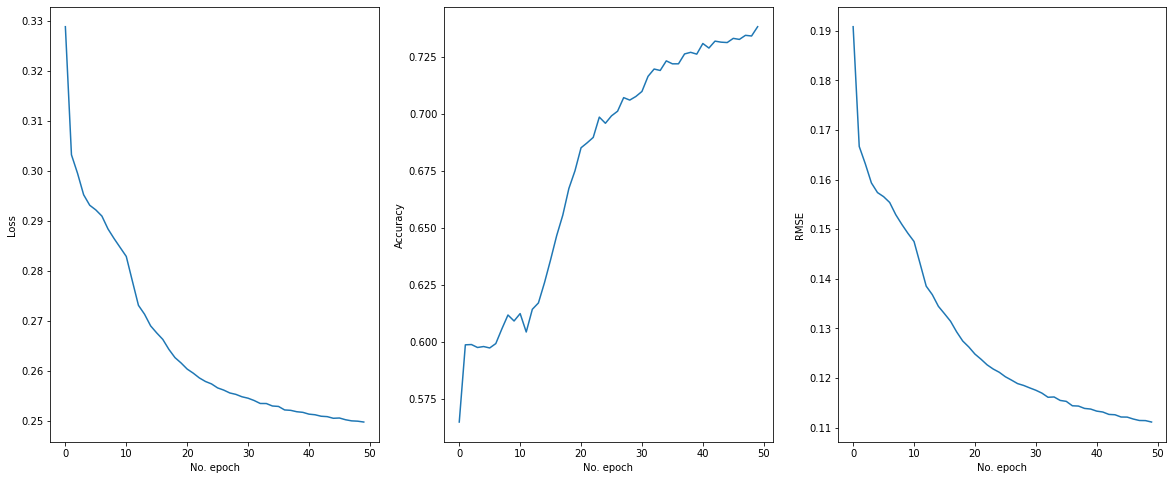

In [7]:
plot_history(history)

In [8]:
x_test = np.load(data_dir+"x_test.npy")
y_test = np.load(data_dir+"y_test.npy")

In [9]:
def accuracy_score_from_distribution(preds, true):
  if len(preds) != len(true):
    return "error"

  correct = 0

  for i in range(len(preds)):
    prediction = preds[i].argmax()
    truth = true[i].argmax()
    
    if prediction == truth:
      correct += 1

  return correct / len(preds)

In [10]:
predictions = model.predict(x_test)
acc = accuracy_score_from_distribution(predictions, y_test)
acc = round(acc * 100, 2)
print(f"Accuracy: {acc}%")

Accuracy: 75.14%


**~75% accuracy!**

In [11]:
def plot_pred(index, x, preds):
  image = x[index] * 255.0
  predicted_class = classes[preds[index].argmax()]
  probability = max(preds[index])
  plt.imshow(image)
  plt.title(f"{predicted_class} with {format(probability, '.2f')} condifence")
  plt.axis("off")

In [12]:
def plot_prob_dist(index, preds, truths):
  pred = preds[index]
  truth = truths[index]
  pred_class = classes[np.argmax(pred)]
  truth_class = classes[np.argmax(truth)]

  top_10_pred_indices = pred.argsort()[-10:][::-1]
  top_10_pred_values = pred[top_10_pred_indices]
  top_10_pred_classes = classes[top_10_pred_indices]

  prob_dist = plt.bar(np.arange(len(top_10_pred_classes)), 
                      top_10_pred_values,
                      color="grey")
  plt.xticks(np.arange(len(top_10_pred_classes)),
             labels=top_10_pred_classes,
             rotation="vertical")
  
  title = f"Actual class (green): {truth_class}\nModel's primary prediction is "
  
  if pred_class == truth_class:
    plt.title(title+"correct")
  else:
    plt.title(title+"incorrect")
  
  if np.isin(truth_class, top_10_pred_classes):
    prob_dist[np.argmax(top_10_pred_classes == truth_class)].set_color("green")
  

In [13]:
def plot_all(index, x_test, y_test, predictions):
  fig = plt.figure(figsize=(20, 8))

  fig.add_subplot(1, 2, 1)
  plot_pred(index, x_test, predictions)
  fig.add_subplot(1, 2, 2)
  plot_prob_dist(index, predictions, y_test)

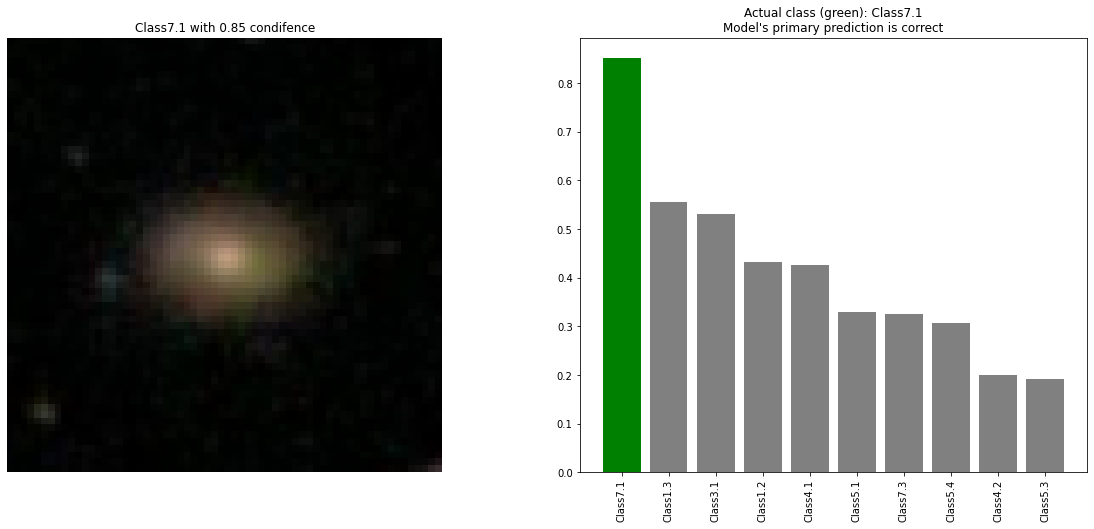

In [14]:
plot_all(1, x_test, y_test, predictions)

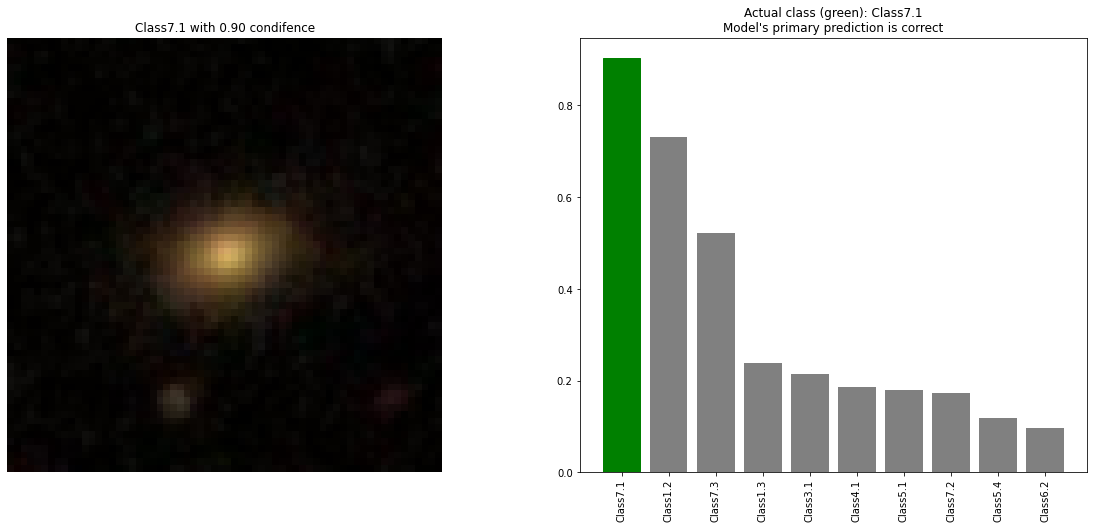

In [15]:
plot_all(100, x_test, y_test, predictions)